# Introduction

We often hear the phrase, "correlation does not imply causation." The thought is that just because two variables are correlated with each other, doesn't mean that one causes the other. This point is easy to illustrate with silly example.

![](https://raw.githubusercontent.com/daniel-saunders-phil/cogs-303/main/correlation_does_not_imply_causation.png)

Perhaps Nicholas Cage should think twice before agreeing to be in Pig 2. 

For the last 100 years or so, it has been common wisdom that statistical information cannot answer causal information. All we see are the correlations. We don't see the causal relationships in the data. Motivated by examples like the graph above, scientists have put really high standards on when and whether we can infer causal relationship. 

But if you take this common wisdom too seriously, it leads you toward other really silly conclusions. I have two in mind. One is is about the writing style in science. The other is about philosophy. Loads of scientific papers are filled with convoluted language to avoid ever asserting that something causes something else. A psychiatric paper studying the effectiveness of an anti-depressant might say that the drug is "associated" with a decrease in the severity of depression. Or they might say the data "suggests" effectiveness. Or, that the drug is "linked" with bad side effects. All of these terms are ambiguous between correlation and causation. They play this little linguistic dance because it's really causation that we care about. No one wants a drug that is correlated but does not actually cause improvements in mental wellbeing. We want causes. But statistics folklore tells us to be quiet and stick to correlations.

Here's the philosophy connection. Let's assume that correlation doesn't imply causation. How then could we ever learn about what causes what? All we ever see in life are the correlations. We don't literally see the causation happening. Causation is some invisible theoretical process. Science is suppose to be objective, about the data that we can all see and agree upon. But sometimes causal situations look identical to non-causal situations when you only look at the data. If Nic Cage filmed caused swimming pool accidents, the data would look just like it does above. David Hume, the guy who gave us the problem of induction, also pointed out the puzzle about how we ever learn about causation from observation. So we are left with a big question, if correlation doesn't imply causation, what does?

To explore these themes, we are going to uses some modeling tools. The main new topic is something called causal graph theory. If you want to know how much a drug improves mental wellbeing, you need a causal graph + a properly specified statistical model. Causal graph theory gives you the tools to design any kind of causal system you want. It also comes with a set of rules for clarifying exactly what we would have to measure and include in a statistical model to correctly estimate the effects we are after.

# Rethinking of our models as regressions

Causal graph theory lets us re-express our statistical models as a network of linear functions. While these networks can get very complex, each linear function is very simple. Before we can appreciate how these networks work, we need to appreciate that all the models we have built so far can be re-expressed as linear functions. This linear function approach is just a way of redescribing models you are already familiar with. 

Let me illustrate by redoing an analysis we did on the Bargh walking speed experiment. Here's the packages.

In [1]:
import numpy as np
import pymc as pm
import matplotlib.pyplot as plt
import arviz as az
import pandas as pd
from scipy import stats
from graphviz import Digraph

and the data.

In [2]:
url = 'https://raw.githubusercontent.com/daniel-saunders-phil/cogs-303/main/bargh_experiment_2_data'

data = pd.read_csv(url)
control = data[data.group == 1]
primed = data[data.group == 0]
control_speed = control.speeds.values
primed_speed = primed.speeds.values
data

,group,speeds
0,0.0,9.610
1,0.0,7.110
2,0.0,7.880
3,0.0,7.380
4,0.0,7.050
5,0.0,8.510
6,0.0,8.260
7,0.0,8.680
8,0.0,7.860
9,0.0,9.020


So far, when we want to compare two groups, we just estimate the parameters of one group, then estimate the parameters of the other group and compare the estimates. So we might want to know the mean walking speed of one group and then learn the mean walking speed of the other group. Here's a simple gadget to remind yourself how that process works. Try to figure out which combination of parameters fit the data best. I've conveniently moved the key parametes to the top of the cell.

log likelihood: -946.6764704961402


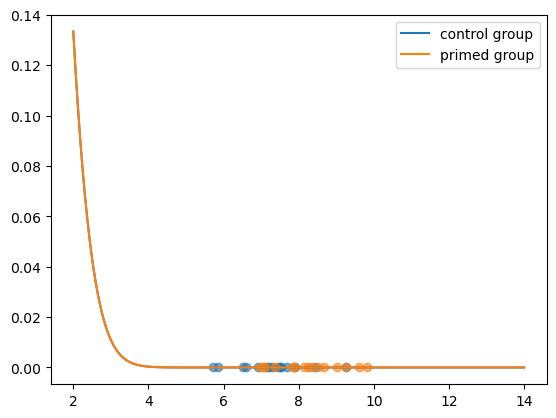

In [3]:
m1=0
m2=0
s1=1
s2=1

def draw_two_normals(m1,m2,s1,s2):
    
    x = np.linspace(2,14,200)
    y1 = stats.norm(m1,s2).pdf(x)
    y2 = stats.norm(m2,s2).pdf(x)
    y1 = y1 / sum(y1)
    y2 = y2 / sum(y2)
    
    l1 = stats.norm(m1,s1).logpdf(control_speed)
    l2 = stats.norm(m2,s2).logpdf(primed_speed)
    
    likelihood = np.sum(l1 + l2)
    print("log likelihood: " + str(likelihood))

    plt.plot(control_speed,[0] * len(control_speed),'o',color="tab:blue",alpha=0.6)
    plt.plot(primed_speed,[0] * len(primed_speed),'o',color="tab:orange",alpha=0.6)
    plt.plot(x,y1,color="tab:blue",label="control group")
    plt.plot(x,y2,color="tab:orange",label="primed group")
    plt.legend()
     
draw_two_normals(m1,m2,s1,s2)

My best answer was roughly:

- m1 = 7.3
- m2 = 8.3
- s1 = 1
- s2 = 1

This should be familiar terrain. Now we can start thinking about another way of describing the same model. Let's flip the whole graph onto its side.

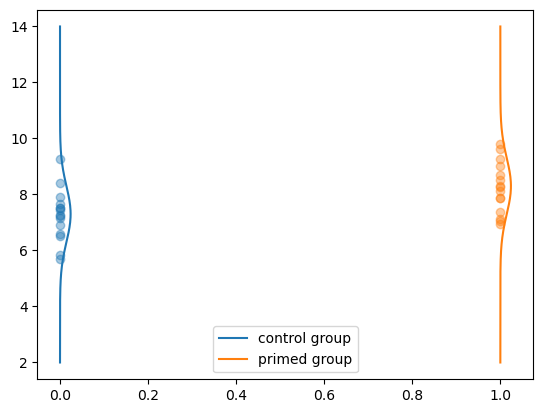

In [33]:
x = np.linspace(2,14,200)
y1 = stats.norm(7.3,1).pdf(x)
y1 = y1 / sum(y1)
y2 = stats.norm(8.3,1).pdf(x)
y2 = y2 / sum(y2)

plt.plot([0] * len(control_speed),control_speed,'o',color="tab:blue",alpha=0.6)
plt.plot([1] * len(primed_speed),primed_speed,'o',color="tab:orange",alpha=0.6)
plt.plot(y1,x,color="tab:blue",label="control group")
plt.plot(y2+1,x,color="tab:orange",label="primed group")
plt.legend()

Group 0 is the control group. Group 1 is the primed group. Each gets its own normal distribution with the same mean as we identified above. Now once we redraw the graph on the side, we can imagine a line running across the graph from the center of the blue dots to the center of the orange dots. This line can be described as a linear function. Let's have $a$ represent the mean of the blue group. Now the mean of the orange group is just a bit higher. We can express how much higher with $b$. Now the big trick is that we can use the variable $x$ to designate which group you are in. The mean of any group is now given by:

$$y = a + b * x$$

When $x$ is 0, we are in the blue group. The $b$ parameter disappears because it's multiplied by zero. When $x$ is 1, the $b$ parameter turns on. We can get a more direct visualization of this function by adjusting the parameters below.

log likelihood: -51.60747049614018


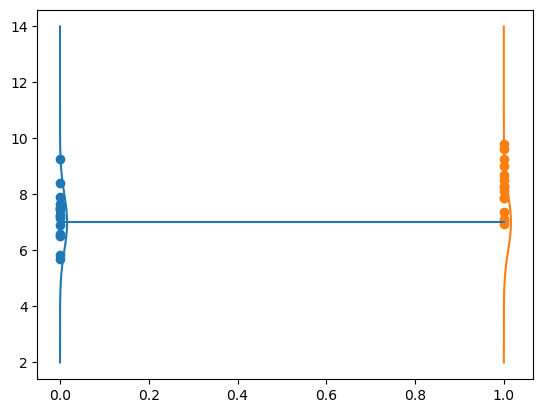

In [5]:
# adjustable parameters

a = 7
b = 0
s = 1

# static

x = np.array([0,1])
plt.plot([0] * len(control_speed),control_speed,'o',color="tab:blue")
plt.plot([1] * len(primed_speed),primed_speed,'o',color="tab:orange")

l1 = stats.norm(a,s).logpdf(control_speed)
l2 = stats.norm(a + b,s).logpdf(primed_speed)
likelihood = np.sum(l1 + l2)

print("log likelihood: " + str(likelihood))

y = a + b*x
plt.plot(x,y)

x = np.linspace(2,14,300)

y1 = stats.norm(y[0],s).pdf(x)
y1 = y1 / sum(y1)
y2 = stats.norm(y[1],s).pdf(x)
y2 = y2 / sum(y2)

plt.plot(y1,x,color="tab:blue",label="control group")
plt.plot(y2+1,x,color="tab:orange",label="primed group")

If you adjust the big parameters to find the line of best fit, you should find roughly:

- a = 7.3
- b = 1
- s = 1

This is equivalent to the answer we got estimating two independent normal distributions. 7.3 + 1 is 8.3, the mean of the second group in both cases. That's pretty neat! So if the later material gets confusing, just remember this linear function strategy is just a natural extension of what you already know, estimating two normals distributions.

## Normal distributions that slide

Why go through all this trouble of rewritting models as linear functions? There are two reasons. 

First, is it allows us combine causal effects from multiple sources. Suppose you thought there were two things that contribute to walking speed, $x_{1}$ and $x_{2}$. To make it more concrete, we can imagine $x_{1}$ is whether or not you are primed. $x_{2}$ can be whether or not you are sleepy. Now if you want to build a model where average walking speed decreases when you are primed and also decreases when you are sleepy, it is just:

$$y = a + b_{1} * x_{1} + b_{2} * x_{2}$$

We'll return to this additive effects strategy in a minute. The second advantage is that it naturally removes the restriction that we only estimate two groups. Now you can estimate any number of groups with the same model. Let's imagine $x$ can take on four possible values: 0, 1, 2, 3. If each additional value of x increases the value of y, then

$$y + a + b*x$$

can express this more complicated situation without changing the model at all. Let's look at what four groups looks like:

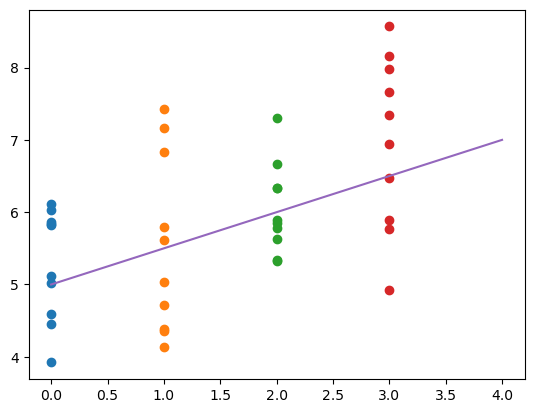

In [20]:
a = 5
b = 0.5
s = 1

x = np.array([0,1,2,3,4])
ys = a + b*x
for i in range(4):
    y_ob = stats.norm(y[i],s).rvs(10)
    plt.plot(np.repeat(x[i],10),y_ob,'o')

plt.plot(x,y)


If we can go from 2 groups to 4 groups, we can also go from 4 groups to any number of groups. You may have seen scatterplots with lines running through them before. These are typically called "regressions". Regressions are a generalization of the normal distribution model but $x$ can more around freely. So these are good if there is some cause that can take on a smooth range of values. For example, if each additional milligram of a psychiatric drug produces a similar change in some mental health outcome, then the range of values $x$ might take on starts at zero and might continue to 100 or whatever the upper limit on the safe dosage is.

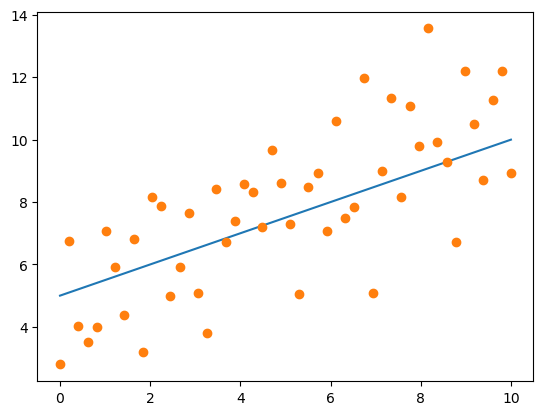

In [13]:
a = 5
b = 0.5
s = 2

x = np.linspace(0,10)
y = a + b*x
y_ob = stats.norm(y,s).rvs()

plt.plot(x,y)
plt.plot(x,y_ob,'o')

So what's going on in the background of these regression lines is that there is a series of normal distributions draw around the center of line and spreading out in both directions. Bayesian estimation attempts to explore which combination of $a$ and $b$ values gives the data high and low likelihoods. It can be helpful to visualize a kind of normal tunnel spreading out around the line. Data points close to the center are most likely. Data points far from the center are less likely. This visualization makes that a bit clearer. I've grabbed 10000 samples and plotted them transparently at each of 50 points along the line.

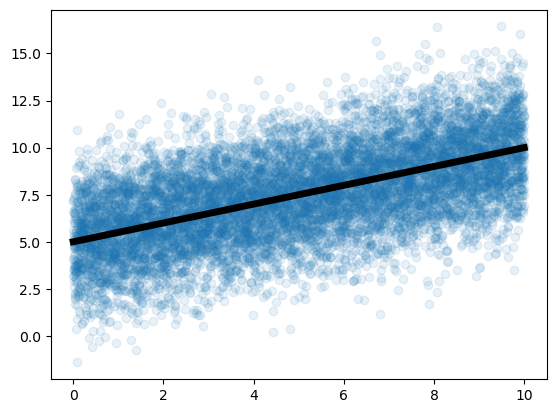

In [8]:
a = 5
b = 0.5
s = 2

x = np.linspace(0,10,10000)
y = a + b*x
y_ob = stats.norm(y,s).rvs()

plt.plot(x,y_ob,'o',alpha=0.1)
plt.plot(x,y,color="black",linewidth=5)

The practical upshot of all of this is that we can build more complex and flexible models by exploiting the same strategy we pursued with estimating two normal distributions. Instead of rewriting your pymc model to estimate three groups, you can write one pymc model that does the whole job at once.

I'll show you how to specify a pymc model that incorporates a linear function. The big change is how we specify priors. Before we tried to make our best guess for what the mean and standard deviation would be for either group and then set our priors there. Typically, we wanted to set our priors to be the same for both groups, which is a way of saying "I'm not sure whether the intervention will work". We can still do that but it's a bit indirect now because of the way we've rewritten the model. $a$ is the mean of the first group. $a + b$ is the mean of the second group. So there isn't a convenient way of specifying one prior for both groups. Instead of we do is put most of our prior information into $a$. Like if we are dealing with walking speeds, we know those have to be positive. So we can put a normal prior over $a$ with a mean in the positive numbers. Then the standard deviation of our prior expresses how uncertain we are about our predicted mean. Finally, we typically use a normal prior around $b$ with mean of zero. This expresses the idea that we don't have prior information about whether the treatment or experiment works in one direction or another. Priming might make people faster or slower. We don't know. That's why we are doing the experiment. So centering our $b$ prior around 0 expresses that.

In [ ]:
with pm.Model() as model_1:
    a = pm.Normal('a',0,50) # i expect my intercept to be around 0 but 
                            # I'm pretty uncertain so I'll use a large standard deviation
    b = pm.Normal('b',0,50) # I expect my slope to be to around 0 but again uncertain
    s = pm.Exponential('s',1) # I expect my standard deviation to be around 1
    
    mean = a + b*x # the linear function part
    
    y = pm.Normal('y',mean,s,observed=y_ob) # the normal distribution moves around the with the linear function
    
    trace = pm.sample()

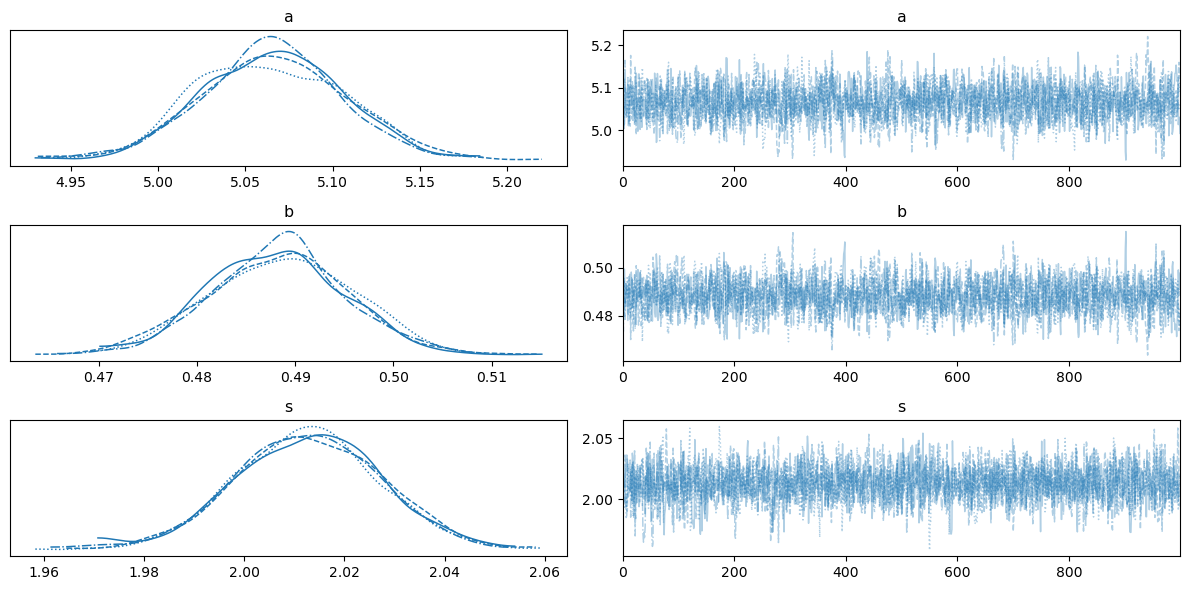

In [12]:
az.plot_trace(trace)
plt.tight_layout();

# Causal graphs

Causal graphs are a formal framework for representing claims about what causes what. There are three ingredients to a causal graph:

- Nodes. These are the variables in the world. Whether or not you are primed, how fast you walk, how happy you are. They migh be counts, continuous, categorical. Nodes are represented by circles.
- Edges. These are the causal influences. We might use numbers to describe how strong a causal influence is or the direction of a causal influence. But numbers are not like variables - we cannot directly measure them. We have to estimate them.
- Direction. Edges have arrows pointing in one (and only) direction. They tell you that some variable causes another but not the other way around. 

So to illustrate, this simple causal graph says priming causes walking speed. But walking speed cannot cause you to be primed. Why? Well, the experimenter decides who gets to be primed or not.

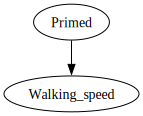

In [46]:
G = Digraph() # set up the graph object

G.node("a",'Primed') # a node to the graph object. Called 'a' but labeled 'primed'
G.node("b",'Walking_speed') # add a second note. Same syntax as above.

G.edge('a','b') # add an edge from a to be
G # display the graph

We can design simulations that follow the logic of causal graphs. We've already been doing this for a while. I just want to make the logic of these simulations a bit more explicit. Any time there is an arrow, that means the variable being pointed at is a linear function of the all the nodes doing the pointing. So walking speed is a linear function of priming.

To construct a simulation for a causal graph, 

1. randomly generate values for all nodes that have no arrows point into them. In our case, priming independent and free of arrows pointing at it. 
2. Take all the nodes where arrows point into them and make them linear functions of their ancestral nodes. 

For example, we generate primed.

In [28]:
# simulate priming data

primed = np.random.randint(low=0,high=2,size=30)
primed

array([1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 1, 1, 0, 0, 0])

And then make walking speed a function of primed.

In [29]:
# linear expression

walking_speed = 8 - 1 * primed
walking_speed

array([7, 7, 8, 8, 7, 8, 7, 8, 7, 7, 8, 8, 7, 7, 7, 8, 7, 7, 8, 7, 7, 7,
       8, 8, 7, 7, 7, 8, 8, 8])

This is the simplest possible causal model. Earlier we also saw one with noise variables:

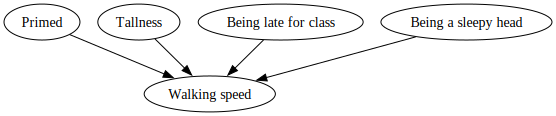

In [6]:
G = Digraph()

G.node("a",'Primed') # generate a node "a", label it "primed" and add it to the graph named dot
G.node("b",'Walking speed')
G.node("n","Tallness")
G.node("k","Being late for class")
G.node("j","Being a sleepy head")

G.edges(['ab']) # connect node a to node b
G.edges(['nb']) # connect node n to node b
G.edges(['kb'])
G.edges(['jb'])
G

And we built a simulation using the same logic, it's just a tad more complex.

In [11]:
primed = np.random.choice([0,1],size=15)
tallness = stats.norm(170,10).rvs(15)
late = np.random.choice([0,1],size=15)
sleepy = np.random.choice([0,1],size=15)

speed_sim = 8 - 0.01 * tallness - 0.5 * late + 0.4 * sleepy + 1 * primed

These simulations are useful because they let use study how statistical models behave against different causal systems. We can ask questions like "what statistical model do I need to write to identify the causal effects, assuming *this* is the causal system. A couple lectures ago, we learned that we only need to measure a single variable (priming) and we can treat the rest as noise.

In [13]:
with pm.Model() as model_1:
    a = pm.Normal('a',10,10) 
    b = pm.Normal('b',0,10)
    s = pm.Exponential('s',1)
    
    mean = a + b*primed
    
    y = pm.Normal('y',mean,s,observed=speed_sim) 
    
    trace = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b, s]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


In [ ]:
az.plot_trace(trace)

# Mediation and causal pathways

Not all causal systems are so easy to estimate. When causal nodes are more tightly connected, things get tricky. One type of structure is mediation.

For Bargh and colleagues, they do not just want to know *whether* or not behavioral priming can effect walking speed. They also want to know the particular causal mechanism by *which* the effect takes place. The whole introduction to paper is an argument for the theoretical plausibility that our minds reproduce automatically and without conscious awareness of environmental cue. So if the effect of behavioral priming travelled through some other route, that wouldn't help their case very much.

Other researchers think it is very plausible the causal effect does travel through another route - experimenters' expectations. If an experimenter thinks you should walk slower leaving the room, they can subtly cue you to walk slower. Maybe they guide you from the table to the door at a slow pace, setting a pace that you follow down the hallway. Maybe they speak in a slow and calm voice to only the primed group to relax them. In the 2012 follow-up study, they have this to say about the potential for experimenter induced bias.

![https://raw.githubusercontent.com/daniel-saunders-phil/cogs-303/main/Bargh_replication.png](https://raw.githubusercontent.com/daniel-saunders-phil/cogs-303/main/Bargh_replication.png)

We can represent this sort of argument with a model also. The big takeaway is that the causal effect Bargh and colleagues are after are *non-identifiable* - which means the experiment they ran cannot identify the causal effect they are after. Let's see what some models look like.

## Unmeasured mediators and non-identifiability

Here is the causal model that the 2012 people are suggesting. If you are primed, then that also turns on experimenter's bias. The experimenter also adds one second to your walking speed. Priming itself might add only a very small amount to your walking speed.

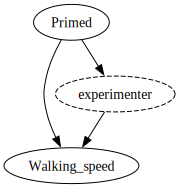

In [45]:
from graphviz import Digraph

G = Digraph()

G.node("a",'Primed')
G.node("b",'Walking_speed')
G.node("c","experimenter",style="dashed")

G.edge('a','c')
G.edge('a','b')
G.edge('c','b')
G

`experimenter` is in a dashed circle because we haven't measured experimenter expectations in the original Asch experiment. Dashed circles are a common notation to distinguished *measured* from *unmeasured* variables.

The 2012 folks think that the size of the causal influences might be something like this:

In [18]:
primed = np.random.choice([0,1],size=10)

experimenter_bias = 1 * primed

speed = 7.3 + 0.9 * experimenter_bias + 0.1 * primed
speed

array([8.3, 8.3, 8.3, 7.3, 7.3, 7.3, 7.3, 8.3, 8.3, 7.3])

Experimenter expectations are the biggest driver of the effect and priming is only a small driver. There are lots of ways we might weight the causal coefficients to produce exactly the same outcome. Here is one where experimenter bias makes people walk *faster* but behavioral priming cancels it out.

In [20]:
speed = 7.3 - 0.1 * experimenter_bias + 1.1 * primed
speed

array([8.3, 8.3, 8.3, 7.3, 7.3, 7.3, 7.3, 8.3, 8.3, 7.3])

Here is another where behavioral priming actually makes people faster but the experimenter_bias effect is so strong that it masks it.

In [21]:
speed = 7.3 + 2 * experimenter_bias - 1 * primed
speed

array([8.3, 8.3, 8.3, 7.3, 7.3, 7.3, 7.3, 8.3, 8.3, 7.3])

All produce the same exact data. So by looking at the data, it is impossible to tell the relative size of the causal effects. This is part of the reason people think correlation doesn't imply causation. The same set of observations can be produced by a variety of 

There is hope, however, if we could break the causal connection between priming and `experimenter expectations`, somehow, we could distangle the effects. This is what the 2012 folks did. They recruited a sample of experimenters to carry out the study. Those experimenters were then told different things about what to expect. Some were told that priming causes you to walk faster, others were told priming makes you walk slower. In this case, the study designers control experimenter expectations, not the priming.

## Measuring mediators and deconfounding

Bargh and colleagues are not unaware of potential problems from mediation. It is just that they explored potential mediation from a different source. Immediately after reporting and discussing the experiment 2a and 2b that we looked at, they run a short follow up study to explore the effect from mediation from mood. Here's the thought - thinking about the elderly might make people sad. And if they are sad, they walk slower. So, it's another possible causal pathway. The real trouble is - sadness is suppose to be a state we are aware of, more or less. If the goal is demonstrate the existence of automatic, subaware mental mechanisms, then having the priming effect travel through mood wouldn't get the job done. Our job is to disentangle the size of causal effects travelling along these pathways.

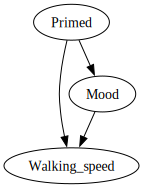

In [44]:
G = Digraph()

G.node("a",'Primed')
G.node("b",'Walking_speed')
G.node("c","Mood")

G.edge('a','c')
G.edge('a','b')
G.edge('c','b')
G

Let's imagine being primed decreases your mood. We'll further imagine that both priming and being sad cause an increase in walking speeds. 

In [23]:
primed = np.random.choice([0,1],size=30)
mood = 3 - 3 * primed
walking_speed = 8 + 1 * primed - 0.5 * mood
walking_speed

array([6.5, 9. , 9. , 9. , 6.5, 9. , 6.5, 9. , 9. , 9. , 9. , 6.5, 9. ,
       6.5, 9. , 6.5, 9. , 9. , 9. , 6.5, 9. , 9. , 9. , 9. , 6.5, 9. ,
       6.5, 6.5, 9. , 6.5])

This graph is unrealistic. We are missing noise factors. Now we have two kinds: noise of mood and noise on walking speed. You would think that mood is caused by more factors that just priming. So we'll draw a noise arrow into it as well.

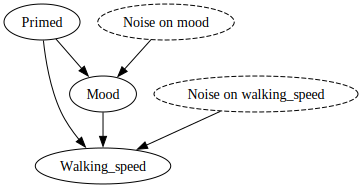

In [24]:
G = Digraph()

G.node("a",'Primed')
G.node("b",'Walking_speed')
G.node("c","Mood")
G.node("n","Noise on mood",style="dashed")
G.node("u","Noise on walking_speed",style="dashed")

G.edge('a','c')
G.edge('a','b')
G.edge('c','b')
G.edge('n','c')
G.edge('u','b')
G

We end up up with a fairly involved causal graph. Here is how we can generate a simulation from this graph:

In [30]:
sample_size = 500

# generate all variables that are not a function of anything

primed = np.random.choice([0,1],size=sample_size) # random assignment to priming condition
noise_on_mood = stats.norm(0,2).rvs(sample_size) # noise
noise_on_walking_speed = stats.norm(0,1).rvs(sample_size) # noise

# mood = baseline mood + priming effect + noise

mood = 3 - 3 * primed + noise_on_mood

# walking speed = baseline + priming effect + mood effect + noise

walking_speed = 8 + 1 * primed - 0.5 * mood + noise_on_walking_speed

In this simulation, I've made up the numbers. That's okay because the point is to illustrate a general principle: if I can construct an artifical world and my statistical machine can learn the important facts about this statistical world, then I can trust that the method works. If the real world was like my made up world, then I know this is the right statistical model to apply. In this case, I have two causal parameters, the priming effect is 1. The mood effect is -0.5. So let's see if our statistical machine can learn the right answers.

Okay now the big question for us: suppose we want to know the *direct* effect of priming on walking speed, which variables do you need to have measurements on? A direct effect is the pathway that leads from priming to walking speed, without traveling down any side routes, like mood. 

In the last example, exploring noise, we learned we need to measure far fewer variables than you might expect. In this example, we have to measure both mood and priming to get the correct estimate. This pymc model illustrates. Notice, also, that we can exploit our additive linear model strategy here. Walking speed is just the sum of two effects.

In [31]:
with pm.Model() as direct_effect:
    a = pm.Normal('Intercept',10,5)
    b1 = pm.Normal('Priming',0,10)
    b2 = pm.Normal('Mood',0,10)
    s = pm.Exponential('Noise',1)
    
    mean = a + b1*primed + b2*mood
    
    y = pm.Normal('y',mean,s,observed=walking_speed)
    
    trace_direct = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Priming, Mood, Noise]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 21 seconds.


In [36]:
az.summary(trace_direct)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,6.587,0.087,6.434,6.761,0.002,0.001,2034.0,2599.0,1.0
Priming,2.586,0.125,2.351,2.808,0.003,0.002,2087.0,2553.0,1.0
Noise,1.371,0.044,1.291,1.454,0.001,0.001,3752.0,3209.0,1.0


We can see that it the model does a fairly good job. It thinks the priming effect is about 1.2. In reality, it is 1. So not so far off. Our model also thinks the mood effect is -0.458. The real mood effect is -0.5. So again really good. We know the real effect sizes because we programmed them into the simulations we built. Simulations serve as a technique for validating that our statistical machines are working as intended.

You might notice that I've cranked up the sample size for this simulation to 500. As causal networks become more complicated, you typically need a corresponding increase in the sample sample size to reliably estimate each component of the model. So you can play around with the sample sizes here to get a sense for what sample size is appropriate for a model of given complexity.

## Direct effect vs total effect

In the last example, we explored the *direct* effect of priming on speed. That is, how causal influence goes directly from priming to speed, without travelling down any side routes. However, there is a different kind of causal estimate we might want, the *total* effect. The total effect includes every possible path from priming to mood. You estimate the total effect by just omitting every mediating variable. 

In [37]:
with pm.Model() as total_effect:
    a = pm.Normal('Intercept',10,5)
    b1 = pm.Normal('Priming',0,10)
    s = pm.Exponential('Noise',1)
    
    mean = a + b1*primed
    
    y = pm.Normal('y',mean,s,observed=walking_speed)
    
    trace_total_effect = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Priming, Noise]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


In [38]:
az.summary(trace_total_effect)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,6.582,0.088,6.428,6.752,0.002,0.001,2107.0,2717.0,1.0
Priming,2.592,0.128,2.363,2.840,0.003,0.002,2076.0,2300.0,1.0
Noise,1.371,0.044,1.289,1.453,0.001,0.001,2905.0,2753.0,1.0


The resulting estimate is about 2.5 for the priming effect. So the total effect is much larger than the direct effect. 

Why 2.5? Well 2.5 is the sum of two different causal pathways. The first causal pathway is the direct one, just 1. The second causal pathway is more complicated. But notice that priming causes a -3 effect on mood. And then mood causes a -0.5 effect on speed. And -3 * -0.5 = 1.5. The really neat part is that 1 (direct path) + 1.5 (indirect path) is 2.5 (total effect). So the causal graphs have this amazing property where the total effect is just the sum of each distinct causal pathway.

To make that additivity property more explicit, it helps to visualize this.

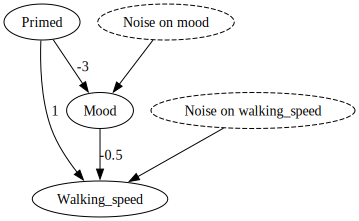

In [52]:
G = Digraph()

G.node("a",'Primed')
G.node("b",'Walking_speed')
G.node("c","Mood")
G.node("n","Noise on mood",style="dashed")
G.node("u","Noise on walking_speed",style="dashed")

G.edge('a','c','-3')
G.edge('a','b','1')
G.edge('c','b','-0.5')
G.edge('n','c')
G.edge('u','b')
G

The takeaway message is that the proper causal model depends on whether you care about the direct or total effect. Sometimes, we just care about the total effect. If you want to know whether a psychiatric drug causes a decrease in anxiety, you might not care about *how* it causes the reduction. In that case, a total effect might be be appropriate. We don't have to always decompose our effect estimate into direct paths. 

However, in basic scientific research, we often do studies just to understand which psychological or physiological mechanisms are operative. That's the whole point of the research. Bargh et al want to know whether the effect travels through subaware or aware pathways. In this case, they need to estimate a direct effect.

## The ideal vs the practice

So far we've just explored made up data. This is helpful for getting intuitions about how causal inference works. But the real world is a little bit more complicated. We don't always have all the data we want. In Bargh's case, they didn't measure mood *during* the original experiments. Instead, they studied the effect of priming on mood in a follow-up study. In the follow-up, we didn't get walking speed data. So we have a bit of a jigsaw puzzle on our hands in putting all these pieces of data together.

Our problem looks a bit like this.

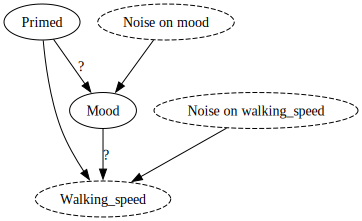

In [57]:
G = Digraph()

G.node("a",'Primed')
G.node("b",'Walking_speed',style="dashed")
G.node("c","Mood",)
G.node("n","Noise on mood",style="dashed")
G.node("u","Noise on walking_speed",style="dashed")

G.edge('a','c','?')
G.edge('a','b')
G.edge('c','b','?')
G.edge('n','c')
G.edge('u','b')
G

We don't know the walking speeds. That's okay though. We just want to estimate the effect of priming on mood. If priming has no effect on mood, we can safely say that our original analysis is safe from mediators. 

If priming does have an effect though, it is hard to know for sure what to make of the original results. It all depends on the subsequent connection between mode and walking speed. Unfornately, without running yet another experiment that connects mood to walking speed, we cannot know what that effect is. So let's find our whether that first question mark is 0 or not?

In [48]:
url = 'https://raw.githubusercontent.com/daniel-saunders-phil/cogs-303/main/bargh_experiment_2_point_1_data'

data = pd.read_csv(url)
data

,primed,mood
0,1,4
1,1,2
2,1,2
3,1,-2
4,0,1
5,0,3
6,1,1
7,0,1
8,1,-1
9,1,7


The mood data is measured on a discrete scale. However, it is not a count. When someone says "rate your mood on a scale of 1-10", there is no sense in which you complete 10 trials with some probability of success. So the binomial model is inappriate. 

The most appriate model is an ordered categorical. That's beyond the scope of our class. The second best we can do is treat it as continuous data and fit a normal distribution.

In [49]:
primed = data.primed.values
mood = data.mood.values

with pm.Model() as direct_inference:
    a = pm.Normal('Intercept',0,5)
    b1 = pm.Normal('Priming',0,5)
    s = pm.Exponential('Noise',1)
    
    mean = a + b1*primed
    
    y = pm.Normal('y',mean,s,observed=mood)
    
    trace_direct = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, Priming, Noise]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 19 seconds.


In [50]:
az.summary(trace_direct)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Intercept,-0.014,0.556,-1.002,1.072,0.013,0.009,1760.0,2206.0,1.0
Priming,1.669,0.717,0.284,2.965,0.017,0.013,1767.0,1843.0,1.0
Noise,2.020,0.253,1.565,2.485,0.005,0.004,2195.0,2299.0,1.0


Well it looks like priming improves people's mood. In this case, it's hard to tell whether the effect of priming is mediated by mood or not. 